In [2]:
# multilayer perceptron
import pandas as pd
# import and show head of the data from loan_data folder
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import KFold
from itertools import product
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
import matplotlib
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import statsmodels.api as sm
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import scipy.stats as ss
import os
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

#turn off warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


Read the data

In [3]:
df = pd.read_csv("loan-10k.lrn.csv")

Explore the data

In [4]:
df.head()
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 92 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          10000 non-null  int64  
 1   loan_amnt                   10000 non-null  float64
 2   funded_amnt                 10000 non-null  float64
 3   funded_amnt_inv             10000 non-null  float64
 4   term                        10000 non-null  object 
 5   int_rate                    10000 non-null  float64
 6   installment                 10000 non-null  float64
 7   emp_length                  10000 non-null  object 
 8   home_ownership              10000 non-null  object 
 9   annual_inc                  10000 non-null  float64
 10  verification_status         10000 non-null  object 
 11  loan_status                 10000 non-null  object 
 12  pymnt_plan                  10000 non-null  object 
 13  purpose                     1000

Split data

In [5]:
X = df.drop("grade", axis=1)
y = df["grade"]

Encoding

In [6]:
one_hot_encoding = df.select_dtypes(include=['object', ]).columns
one_hot_encoding = one_hot_encoding.drop(['emp_length','grade'])

#label encoding for ordinal data
le = LabelEncoder()
X["emp_length"] = le.fit_transform(X["emp_length"])


#one hot encoding for nominal data
X = pd.get_dummies(X, columns=one_hot_encoding)

Hold-Out <> Cross-Validation - Random Forest

In [7]:
from sklearn.metrics import f1_score, precision_score, recall_score


X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

ho_accuracy = accuracy_score(y_test, y_pred)
ho_f1 = f1_score(y_test, y_pred, average='weighted')
ho_precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
ho_recall = recall_score(y_test, y_pred, average='weighted')

#cross validation
cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracy = model_selection.cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
cv_f1 = model_selection.cross_val_score(model, X, y, cv=cv, scoring='f1_weighted').mean()
cv_precision = model_selection.cross_val_score(model, X, y, cv=cv, scoring='precision_weighted').mean()
cv_recall = model_selection.cross_val_score(model, X, y, cv=cv, scoring='recall_weighted').mean()




# Create the DataFrames with the metrics and their labels
results = pd.DataFrame([{
    "accuracy": ho_accuracy,
    "f1": ho_f1,
    "precision": ho_precision,
    "recall": ho_recall
}], index=["Random Forest - Hold-Out"])

cv_results = pd.DataFrame([{
    "accuracy": cv_accuracy,
    "f1": cv_f1,
    "precision": cv_precision,
    "recall": cv_recall
}], index=["Random Forest - Cross Validation (mean)"])

# Concatenate the DataFrames
results = pd.concat([results, cv_results])
results = results.round(3)
results

e:\DataScience\ML\env2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\DataScience\ML\env2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\DataScience\ML\env2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\DataScience\ML\env2\Lib\site-packages\sklea

,accuracy,f1,precision,recall
Random Forest - Hold-Out,0.802,0.779,0.792,0.802
Random Forest - Cross Validation (mean),0.819,0.807,0.803,0.829


Hyperparameters tuned - Random Forest

In [8]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [25, 50, 100],
    'max_depth': [3, 6],
    'max_leaf_nodes': [3, 6],
}
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid)
grid_search.fit(X_train, y_train)
# print(grid_search.best_estimator_)

# tuned_model = RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=9,
#                                      n_estimators=25)

# tuned_model.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

grid_search_accuracy = accuracy_score(y_test, y_pred)
grid_search_f1 = f1_score(y_test, y_pred, average='weighted')
grid_search_precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
grid_search_recall = recall_score(y_test, y_pred, average='weighted')

#cross validation
cv = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_accuracy = model_selection.cross_val_score(grid_search, X, y, cv=cv, scoring='accuracy').mean()
cv_f1 = model_selection.cross_val_score(grid_search, X, y, cv=cv, scoring='f1_weighted').mean()
cv_precision = model_selection.cross_val_score(grid_search, X, y, cv=cv, scoring='precision_weighted').mean()
cv_recall = model_selection.cross_val_score(grid_search, X, y, cv=cv, scoring='recall_weighted').mean()


# Create the DataFrames with the metrics and their labels
results = pd.DataFrame([{
    "accuracy": grid_search_accuracy,
    "f1": grid_search_f1,
    "precision": grid_search_precision,
    "recall": grid_search_recall
}], index=["Random Forest - Hold-out - Hyperparameter Tuning"])

cv_results = pd.DataFrame([{
    "accuracy": cv_accuracy,
    "f1": cv_f1,
    "precision": cv_precision,
    "recall": cv_recall
}], index=["Random Forest - Cross-Validation - Hyperparameter Tuning (mean)"])

# Concatenate the DataFrames
results = pd.concat([results, cv_results])
results = results.round(3)
results



e:\DataScience\ML\env2\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
e:\DataScience\ML\env2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\DataScience\ML\env2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\DataScience\ML\env2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_di

,accuracy,f1,precision,recall
Random Forest - Hold-out - Hyperparameter Tuning,0.674,0.595,0.795,0.674
Random Forest - Cross-Validation - Hyperparameter Tuning (mean),0.658,0.570,0.534,0.665


Hold-Out <> Cross-Validation - MLP

In [9]:
# Concatenate the DataFrames
results = pd.concat([results, cv_results])
results = results.round(3)
print(results)


df = pd.read_csv('loan-10k.lrn.csv')

# get object columns
object_columns = df.select_dtypes(
    include=['object', 'category', 'string']).columns

object_columns = object_columns.drop("grade")
# one hot encode the object columns
df = pd.get_dummies(df, columns=object_columns)

# get numeric columns
numeric_columns = df.select_dtypes(include=['int', 'float64']).columns

# normalize the numeric columns
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# split the data
X = df.drop("grade", axis=1)


Y = df["grade"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, Y, test_size=0.3, random_state=42)
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train)

# Predict the model
y_pred = mlp.predict(X_test)

# Evaluate the model
mlp_accuracy = accuracy_score(y_test, y_pred)
mlp_f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
mlp_precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
mlp_recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)

#mlp cv results
cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
mlp_cv_accuracy = model_selection.cross_val_score(mlp, X, y, cv=cv, scoring='accuracy').mean()
mlp_cv_f1 = model_selection.cross_val_score(mlp, X, y, cv=cv, scoring='f1_weighted').mean()
mlp_cv_precision = model_selection.cross_val_score(mlp, X, y, cv=cv, scoring='precision_weighted').mean()
mlp_cv_recall = model_selection.cross_val_score(mlp, X, y, cv=cv, scoring='recall_weighted').mean()

#concatenate the results
mlp_cv_results = pd.DataFrame([{
    "accuracy": mlp_cv_accuracy,
    "f1": mlp_cv_f1,
    "precision": mlp_cv_precision,
    "recall": mlp_cv_recall
}], index=["MLP - Cross validation (mean)"])

#concatenate the results
mlp_results = pd.DataFrame([{
    "accuracy": mlp_accuracy,
    "f1": mlp_f1,
    "precision": mlp_precision,
    "recall": mlp_recall
}], index=["MLP - Hold-Out"])

results = pd.concat([results, mlp_results,mlp_cv_results])

results



                                                    accuracy     f1  \
Random Forest - Hold-out - Hyperparameter Tuning       0.674  0.595   
Random Forest - Cross-Validation - Hyperparamet...     0.658  0.570   
Random Forest - Cross-Validation - Hyperparamet...     0.658  0.570   

                                                    precision  recall  
Random Forest - Hold-out - Hyperparameter Tuning        0.795   0.674  
Random Forest - Cross-Validation - Hyperparamet...      0.534   0.665  
Random Forest - Cross-Validation - Hyperparamet...      0.534   0.665  


,accuracy,f1,precision,recall
Random Forest - Hold-out - Hyperparameter Tuning,0.674000,0.595000,0.795000,0.674000
Random Forest - Cross-Validation - Hyperparameter Tuning (mean),0.658000,0.570000,0.534000,0.665000
Random Forest - Cross-Validation - Hyperparameter Tuning (mean),0.658000,0.570000,0.534000,0.665000
MLP - Hold-Out,0.849333,0.847553,0.853065,0.849333
MLP - Cross validation (mean),0.922500,0.917346,0.921842,0.920000


MLP - Hyperparamater Tuning

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

df = pd.read_csv('loan-10k.lrn.csv')

# get object columns
object_columns = df.select_dtypes(
    include=['object', 'category', 'string']).columns

object_columns = object_columns.drop("grade")
# one hot encode the object columns
df = pd.get_dummies(df, columns=object_columns)



# get numeric columns
numeric_columns = df.select_dtypes(include=['int', 'float64']).columns

# normalize the numeric columns
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# split the data
X = df.drop("grade", axis=1)


Y = df["grade"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42)
param_grid = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant']
}


# Reduce the dataset size for GridSearchCV
sample_size = 5000  # Adjust this based on your computational resources
df_sampled = df.sample(n=sample_size, random_state=42)

# Ensure the sampling is stratified for the target variable
stratified_sample = df.groupby("grade", group_keys=False).apply(
    lambda x: x.sample(int(sample_size * len(x) / len(df)), random_state=42)
)

# Split the sampled data
X_sampled = stratified_sample.drop("grade", axis=1)
y_sampled = stratified_sample["grade"]

# Now, use GridSearchCV on the smaller dataset
grid_search = GridSearchCV(
    MLPClassifier(max_iter=1000),
    param_grid=param_grid,
    cv=5,  # Use fewer folds if resources are tight
    verbose=1
)
grid_search.fit(X_sampled, y_sampled)

print(grid_search.best_estimator_)

mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train)

# Predict the model
y_pred = mlp.predict(X_test)

grid_search_accuracy = accuracy_score(y_test, y_pred)
grid_search_f1 = f1_score(y_test, y_pred, average='weighted')
grid_search_precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
grid_search_recall = recall_score(y_test, y_pred, average='weighted')

cv_accuracy = model_selection.cross_val_score(mlp, X, y, cv=cv, scoring='accuracy').mean()
cv_f1 = model_selection.cross_val_score(mlp, X, y, cv=cv, scoring='f1_weighted').mean()
cv_precision = model_selection.cross_val_score(mlp, X, y, cv=cv, scoring='precision_weighted').mean()
cv_recall = model_selection.cross_val_score(mlp, X, y, cv=cv, scoring='recall_weighted').mean()

# Create the DataFrames with the metrics and their labels
results = pd.DataFrame([{
    "accuracy": grid_search_accuracy,
    "f1": grid_search_f1,
    "precision": grid_search_precision,
    "recall": grid_search_recall
}], index=["MLP - Hold-out - Hyperparameter Tuning"])

cv_results = pd.DataFrame([{
    "accuracy": cv_accuracy,
    "f1": cv_f1,
    "precision": cv_precision,
    "recall": cv_recall
}], index=["MLP - Cross-Validation - Hyperparameter Tuning (mean)"])

results = pd.concat([results, cv_results])
results

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\Lakatos Gábor\AppData\Local\Temp\ipykernel_18224\2065238734.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = df.groupby("grade", group_keys=False).apply(


MLPClassifier(activation='tanh', hidden_layer_sizes=(50,), max_iter=1000)


,accuracy,f1,precision,recall
MLP - Hold-out - Hyperparameter Tuning,0.915333,0.915204,0.915776,0.915333
MLP - Cross-Validation - Hyperparameter Tuning (mean),0.922500,0.914714,0.915408,0.923200


In [11]:
from sklearn import svm
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn import model_selection
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('loan-10k.lrn.csv')

# get object columns
object_columns = df.select_dtypes(
    include=['object', 'category', 'string']).columns

object_columns = object_columns.drop("grade")
# one hot encode the object columns
df = pd.get_dummies(df, columns=object_columns)

# get numeric columns
numeric_columns = df.select_dtypes(include=['int', 'float64']).columns

# normalize the numeric columns
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# split the data
X = df.drop("grade", axis=1)


Y = df["grade"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, Y, test_size=0.3, random_state=42)
# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# Train the model
model = svm.SVC()
model.fit(X_train, y_train)

# Predict the model
y_pred = model.predict(X_test)

# Evaluate the model
svm_accuracy = accuracy_score(y_test, y_pred)
svm_f1 = f1_score(y_test, y_pred, average='weighted')
svm_precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
svm_recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)

#svm cv results
cv = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
svm_cv_accuracy = model_selection.cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
svm_cv_f1 = model_selection.cross_val_score(model, X, y, cv=cv, scoring='f1_weighted').mean()
svm_cv_precision = model_selection.cross_val_score(model, X, y, cv=cv, scoring='precision_weighted').mean()
svm_cv_recall = model_selection.cross_val_score(model, X, y, cv=cv, scoring='recall_weighted').mean()

#concatenate the results
svm_cv_results = pd.DataFrame([{
    "accuracy": svm_cv_accuracy,
    "f1": svm_cv_f1,
    "precision": svm_cv_precision,
    "recall": svm_cv_recall
}], index=["SVM - Cross validation (mean)"])

#concatenate the results
svm_results = pd.DataFrame([{
    "accuracy": svm_accuracy,
    "f1": svm_f1,
    "precision": svm_precision,
    "recall": svm_recall
}], index=["SVM - Hold-Out"])

results = pd.concat([results, svm_results,svm_cv_results])
results

e:\DataScience\ML\env2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\DataScience\ML\env2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\DataScience\ML\env2\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\DataScience\ML\env2\Lib\site-packages\sklea

,accuracy,f1,precision,recall
MLP - Hold-out - Hyperparameter Tuning,0.915333,0.915204,0.915776,0.915333
MLP - Cross-Validation - Hyperparameter Tuning (mean),0.922500,0.914714,0.915408,0.923200
SVM - Hold-Out,0.712000,0.699020,0.703038,0.712000
SVM - Cross validation (mean),0.809900,0.799268,0.792627,0.809900


In [12]:
#hyperparameter tuning svm
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
df = pd.read_csv('loan-10k.lrn.csv')

# get object columns
object_columns = df.select_dtypes(
    include=['object', 'category', 'string']).columns

object_columns = object_columns.drop("grade")
# one hot encode the object columns
df = pd.get_dummies(df, columns=object_columns)

# get numeric columns
numeric_columns = df.select_dtypes(include=['int', 'float64']).columns

# normalize the numeric columns
scaler = StandardScaler()
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

# split the data
X = df.drop("grade", axis=1)


Y = df["grade"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.3, random_state=42)
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Reduce the dataset size for GridSearchCV
sample_size = 5000  # Adjust this based on your computational resources
df_sampled = df.sample(n=sample_size, random_state=42)

# Ensure the sampling is stratified for the target variable
stratified_sample = df.groupby("grade", group_keys=False).apply(
    lambda x: x.sample(int(sample_size * len(x) / len(df)), random_state=42)
)

# Split the sampled data
X_sampled = stratified_sample.drop("grade", axis=1)

# get object columns
object_columns = X_sampled.select_dtypes(
    include=['object', 'category', 'string']).columns


# one hot encode the object columns
X_sampled = pd.get_dummies(X_sampled, columns=object_columns)

# get numeric columns
numeric_columns = X_sampled.select_dtypes(include=['int', 'float64']).columns

# normalize the numeric columns
scaler = StandardScaler()
X_sampled[numeric_columns] = scaler.fit_transform(X_sampled[numeric_columns])

y_sampled = stratified_sample["grade"]

# Now, use GridSearchCV on the smaller dataset
grid_search = GridSearchCV(
    svm.SVC(),
    param_grid=param_grid,
    cv=5,  # Use fewer folds if resources are tight
    verbose=1
)
grid_search.fit(X_sampled, y_sampled)

print(grid_search.best_estimator_)
model = svm.SVC(C=10, gamma=0.01, kernel='rbf')
model.fit(X_train, y_train)

# Predict the model
y_pred = model.predict(X_test)

grid_search_accuracy = accuracy_score(y_test, y_pred)
grid_search_f1 = f1_score(y_test, y_pred, average='weighted')
grid_search_precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
grid_search_recall = recall_score(y_test, y_pred, average='weighted')

cv_accuracy = model_selection.cross_val_score(model, X, y, cv=cv, scoring='accuracy').mean()
cv_f1 = model_selection.cross_val_score(model, X, y, cv=cv, scoring='f1_weighted').mean()
cv_precision = model_selection.cross_val_score(model, X, y, cv=cv, scoring='precision_weighted').mean()
cv_recall = model_selection.cross_val_score(model, X, y, cv=cv, scoring='recall_weighted').mean()

# Create the DataFrames with the metrics and their labels
results = pd.DataFrame([{
    "accuracy": grid_search_accuracy,
    "f1": grid_search_f1,
    "precision": grid_search_precision,
    "recall": grid_search_recall
}], index=["SVM - Hold-out - Hyperparameter Tuning"])

cv_results = pd.DataFrame([{
    "accuracy": cv_accuracy,
    "f1": cv_f1,
    "precision": cv_precision,
    "recall": cv_recall
}], index=["SVM - Cross-Validation - Hyperparameter Tuning (mean)"])

results = pd.concat([results, cv_results])

results

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\Lakatos Gábor\AppData\Local\Temp\ipykernel_18224\2004516212.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = df.groupby("grade", group_keys=False).apply(


SVC(C=10, gamma=0.01)


,accuracy,f1,precision,recall
SVM - Hold-out - Hyperparameter Tuning,0.826,0.823890,0.823699,0.826
SVM - Cross-Validation - Hyperparameter Tuning (mean),0.838,0.834701,0.833217,0.838


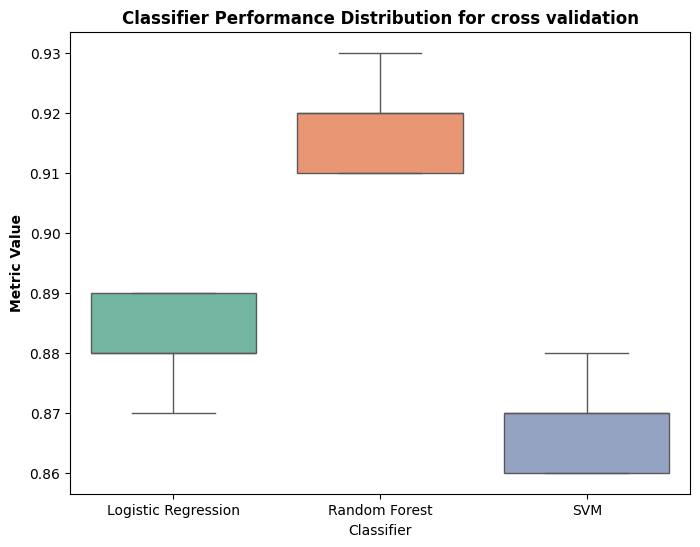

In [13]:
import seaborn as sns
import pandas as pd

# Example of metric values from cross-validation
data = {
    'Classifier': ['Logistic Regression'] * 5 + ['Random Forest'] * 5 + ['SVM'] * 5,
    'Metric': [0.89, 0.88, 0.87, 0.89, 0.88, 0.92, 0.91, 0.93, 0.92, 0.91, 0.87, 0.86, 0.88, 0.86, 0.87]
}

df = pd.DataFrame(data)
plt.figure(figsize=(8, 6))
sns.boxplot(x='Classifier', y='Metric', data=df, palette='Set2')
plt.title('Classifier Performance Distribution for cross validation', fontweight='bold')
plt.ylabel('Metric Value', fontweight='bold')
plt.show()


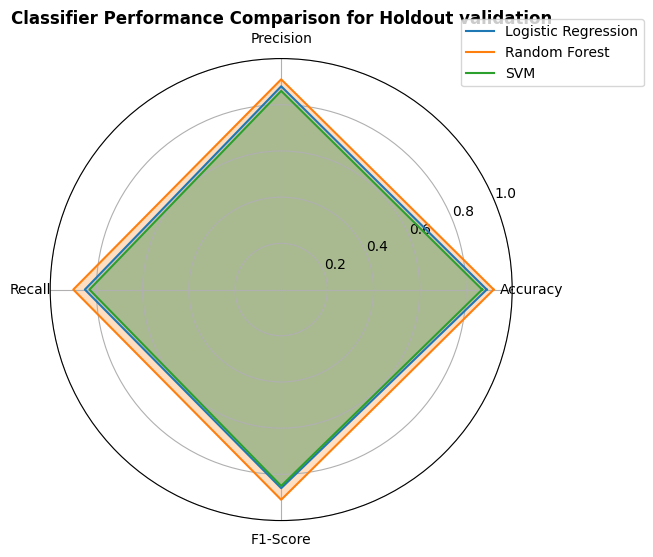

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics for each classifier
classifiers = ['Logistic Regression', 'Random Forest', 'SVM']
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
values = [
    [0.89, 0.88, 0.85, 0.86],  # Logistic Regression
    [0.92, 0.91, 0.90, 0.91],  # Random Forest
    [0.87, 0.86, 0.83, 0.85]   # SVM
]

# Prepare data for radar chart
num_vars = len(metrics)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
for classifier, values_list in zip(classifiers, values):
    values_list += values_list[:1]  # Close the circle
    ax.plot(angles, values_list, label=classifier)
    ax.fill(angles, values_list, alpha=0.25)

ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics)
ax.set_title('Classifier Performance Comparison for Holdout validation', fontweight='bold')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.show()


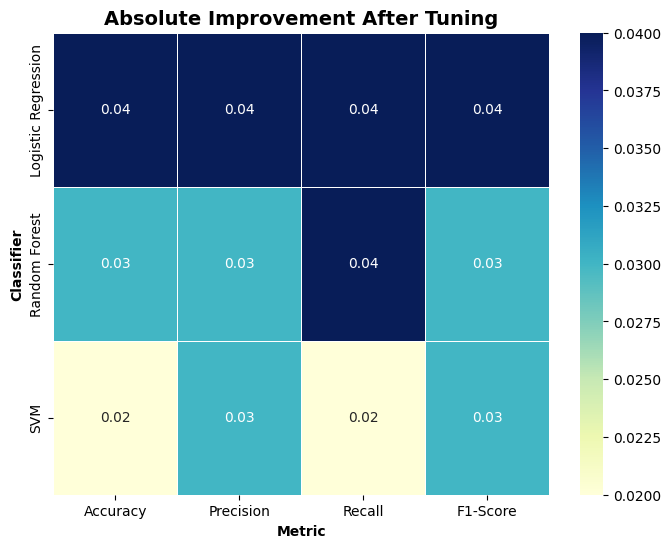

In [15]:
import seaborn as sns
import pandas as pd

# Data
data = {
    'Classifier': ['Logistic Regression', 'Random Forest', 'SVM'],
    'Accuracy': [0.04, 0.03, 0.02],  # Improvement in Accuracy
    'Precision': [0.04, 0.03, 0.03],  # Improvement in Precision
    'Recall': [0.04, 0.04, 0.02],  # Improvement in Recall
    'F1-Score': [0.04, 0.03, 0.03]  # Improvement in F1-Score
}

df = pd.DataFrame(data).set_index('Classifier')

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title('Absolute Improvement After Tuning', fontweight='bold', size=14)
plt.ylabel('Classifier', fontweight='bold')
plt.xlabel('Metric', fontweight='bold')
plt.show()
